# Modeling to Predict Changes in Peloton Stock (PTON)

PTON was first stock to make me interested in using Google Trends to predict stock price changes. Search interest for 'PTON' was at an all-time high in September 2020, and in the months following the value of the stock doubled in value. This is why I am going to model for PTON first. My hypothesis is that using Google Trends will improve my model's ability to accurately predict the rise of Peloton in 2020.

In [359]:
#Imports
from alpha_vantage.timeseries import TimeSeries
import requests
import pandas as pd
import pandas as pd                        
from pytrends.request import TrendReq
from IPython.display import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [360]:
#see API_setup.ipynb for how I created these functions
def spdr_adj_close():
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=spy&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    return df['5. adjusted close']

def create_ticker_df (ticker):
    '''Returns a DataFrame of stock and Google Trends data for the given ticker. The output will be daily data 1/2/18-6/1/21'''
    #collect stock data using Alpha Vantage API
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    
    #filter to include 2018.01.02 - 2021.06.01
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    
    #add lag columns
    days_to_lag = [1,2,3,7,30,90,365]
    for day in days_to_lag:
        df[f'lag_{day}'] = df['5. adjusted close'].shift(day)
    
    #fix dtypes and column names
    df['spdr_adj_close'] = spdr_adj_close()
   
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    df['daily_returns'] = df['5. adjusted close'] - df['lag_1']
    df['daily_pct_return'] = df['daily_returns']/df['5. adjusted close'].shift(1)
    df['rolling_3d_adj_close'] = df['5. adjusted close'].rolling(3).mean()
    df.rename(columns = {'1. open': 'open',
                        '2. high': 'high',
                        '3. low': 'low',
                        '4. close': 'close',
                        '5. adjusted close': 'adjusted_close',
                        '6. volume': 'volume',
                        '7. dividend amount': 'dividend amount',
                        '8. split coefficient': 'splitcoef',
                        'daily_returns' : 'daily_returns'}, inplace = True)
        
    #Collect Google Trends data using pytrends api
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[ticker])
    google = pytrend.interest_over_time()
    trends = google[ticker].resample('D', convention = 'start').pad()
    trends = pd.DataFrame(trends)
    trends.rename(columns = {ticker:'trend_score'}, inplace = True)
    
    #merge stock data with trends data
    df = df.merge(trends, how = 'left', left_index = True, right_index = True)
    
    return df

In [361]:
pton = create_ticker_df('PTON')

In [362]:
pton

,open,high,low,close,adjusted_close,volume,dividend amount,splitcoef,lag_1,lag_2,lag_3,lag_7,lag_30,lag_90,lag_365,spdr_adj_close,daily_returns,daily_pct_return,rolling_3d_adj_close,trend_score
date,,,,,,,,,,,,,,,,,,,,
2019-09-26,27.0000,27.980,24.75,25.76,25.76,47067673,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.129235,NaN,NaN,NaN,35
2019-09-27,26.1700,26.170,23.75,25.24,25.24,15975986,0.0,1.0,25.76,NaN,NaN,NaN,NaN,NaN,NaN,286.577023,-0.52,-0.020186,NaN,35
2019-09-30,25.2600,25.850,25.00,25.10,25.10,4482931,0.0,1.0,25.24,25.76,NaN,NaN,NaN,NaN,NaN,287.906104,-0.14,-0.005547,25.366667,21
2019-10-01,25.0000,25.170,22.51,22.51,22.51,8816118,0.0,1.0,25.10,25.24,25.76,NaN,NaN,NaN,NaN,284.481538,-2.59,-0.103187,24.283333,21
2019-10-02,22.2500,23.180,21.76,22.60,22.60,9454724,0.0,1.0,22.51,25.10,25.24,NaN,NaN,NaN,NaN,279.456254,0.09,0.003998,23.403333,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,101.1600,102.720,98.68,99.44,99.44,9340217,0.0,1.0,101.16,100.90,100.46,96.58,122.36,165.25,32.03,416.857700,-1.72,-0.017003,100.500000,25
2021-05-26,99.9600,110.490,99.96,109.56,109.56,26620603,0.0,1.0,99.44,101.16,100.90,92.29,117.80,157.81,30.85,417.684956,10.12,0.101770,103.386667,25
2021-05-27,109.3200,112.899,106.95,112.60,112.60,13568262,0.0,1.0,109.56,99.44,101.16,95.19,119.90,150.14,31.53,417.904229,3.04,0.027747,107.200000,25


# Baseline Model: ARIMA

In [363]:
# Create train-test split.
y_train = pton[pton.index < datetime(year = 2021, month = 3, day = 1)]
y_test = pton[pton.index > datetime(year = 2021, month = 3, day = 1)]
y_train = y_train['daily_pct_return']
y_test = y_test['daily_pct_return'] 
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.dropna(inplace = True)
y_test.dropna(inplace = True)

In [364]:
from statsmodels.tsa.stattools import adfuller

In [365]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [366]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(y_train))

Test Statistic   -1.861373e+01
p-value           2.064081e-30
dtype: float64

Since our p-value is approaching zero that means that our daily_pct_return data is stationary and we are permitted to use an ARIMA model. It makes sense that the daily_pct_return data is stationary considering it's already differenced. The adjusted_close data is not stationary, there has been a lot of movement in the stock price since it's IPO in 2019.

In [367]:
warnings.filterwarnings

<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

In [368]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,1,0) is: -934.0440909911908
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,1,1) is: -1168.7877074340872
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,1,2) is: -1166.8521823487522
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,1,3) is: -1165.454779190161
Attempting to fit ARIMA(0,1,4)
The AIC for ARIMA(0,1,4) is: -1163.590455447542
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,1,0) is: -1021.8127839383114
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,1,1) is: -1166.8470012794514
Attempting to fit ARIMA(1,1,2)
The AIC for ARIMA(1,1,2) is: -1166.099094316111
Attempting to fit ARIMA(1,1,3)
The AIC for ARIMA(1,1,3) is: -1164.441965703711
Attempting to fit ARIMA(1,1,4)
The AIC for ARIMA(1,1,4) is: -1164.5767382357744
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,1,0) is: -1063.693551571017
Attempting to fit ARIMA(2,1,1)
The AIC for ARIMA(2,1,1) is: -1165.4277454320309
Attempting to fit ARIMA(2,1,2)
The AIC for ARI

In [369]:
import datetime as dt

In [370]:
#y_test = y_test.asfreq('d')
#y_test.dropna(inplace = True)

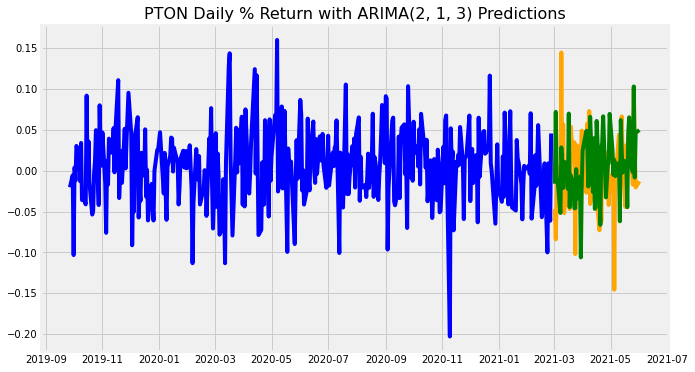

In [371]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (2,1,3))

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params)
preds= preds[292:]

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'PTON Daily % Return with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();

In [372]:
start = 123.81
def make_predicted_adj_close_df(start_adj_close, preds):
    mylist = []
    #mylist = [start_adj_close]
    for day in preds:
        try:
            mylist.append(mylist[-1]*(1+day))
        except:
            mylist.append(start_adj_close)
    return mylist

In [373]:
predicted_adj_close = make_predicted_adj_close_df(start, preds)

In [374]:
close_train = pton[pton.index < datetime(year = 2021, month = 3, day = 1)]
close_test = pton[pton.index > datetime(year = 2021, month = 3, day = 1)]
close_train = close_train['adjusted_close']
close_test = close_test['adjusted_close'] 
close_train = pd.DataFrame(close_train)
close_test = pd.DataFrame(close_test)

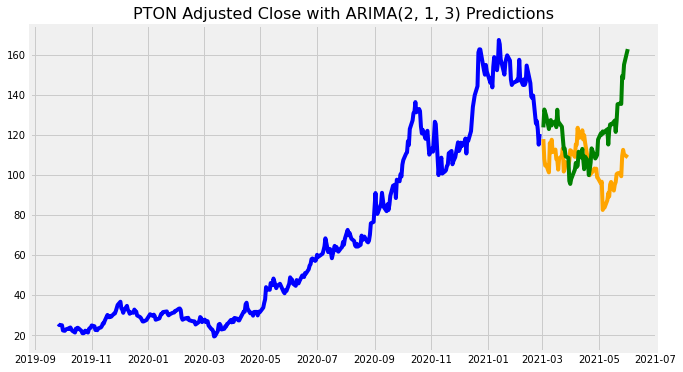

In [375]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(close_train.index, pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
plt.plot(close_test.index, predicted_adj_close, color = 'green')

plt.title(label = 'PTON Adjusted Close with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();

The Blue and yellow lines above are the actual PTON adjusted close amounts. The green line is the ARIMA predictions. As we can see the green line is not close to what actually happened. For a baseline model, however, this is a fine start.


The next step will be to see if we can improve upon this by incorporating Google Trends data.



# ARIMA Model with Exogeneous Predictors

In [376]:
gt_train = pton[pton.index < datetime(year = 2021, month = 3, day = 1)]
gt_train['diff_trend_score']= gt_train['trend_score'].diff(1)

gt_train = gt_train['diff_trend_score']

endog = y_train.astype(float).dropna()
exog = sm.add_constant(gt_train.astype(float).dropna())

In [377]:
endog.shape

(357, 1)

In [378]:
exog.shape

(357, 2)

In [379]:
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(2,1,3))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:       daily_pct_return   No. Observations:                  357
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 591.297
Date:                Tue, 13 Jul 2021   AIC                          -1166.595
Time:                        17:00:49   BIC                          -1135.595
Sample:                             0   HQIC                         -1154.263
                                - 357                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.015e-10   4.66e-09      0.086      0.931   -8.73e-09    9.53e-09
diff_trend_score     0.0005      0.000      1.126      0.260      -0.000       0.001
ar.L1               -1.5124 

In [380]:
preds_with_gt = res.predict()
preds_with_gt = preds_with_gt[292:]

In [381]:
preds_with_gt

date
2020-11-23    0.001414
2020-11-24    0.004598
2020-11-25    0.004574
2020-11-27    0.005581
2020-11-30    0.012033
                ...   
2021-02-22    0.009864
2021-02-23   -0.002355
2021-02-24    0.007987
2021-02-25    0.004781
2021-02-26   -0.005194
Name: predicted_mean, Length: 65, dtype: float64

In [382]:
predicted_adj_close = make_predicted_adj_close_df(start, preds_with_gt)
predicted_adj_close = predicted_adj_close[1:]

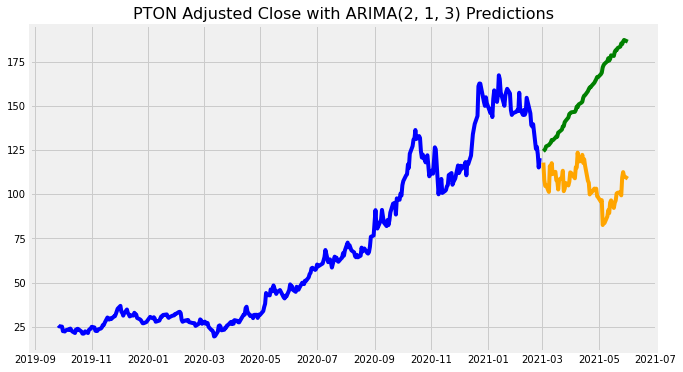

In [383]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(close_train.index, pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
plt.plot(close_test.index, predicted_adj_close, color = 'green')

plt.title(label = 'PTON Adjusted Close with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();